# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

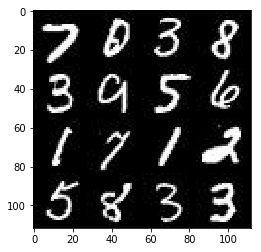

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

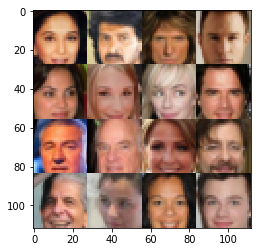

In [4]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28*28*3
        layer1 = tf.layers.conv2d(images, 64, 4, strides=1, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*layer1, layer1)
        dropout1 = tf.nn.dropout(relu1, keep_prob)
        # 28*28*64
        
        layer2 = tf.layers.conv2d(dropout1, 128, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2= tf.maximum(alpha*bn2, bn2)
        dropout2 = tf.nn.dropout(relu2, keep_prob)
        # 14*14*128
        
        layer3 = tf.layers.conv2d(relu2, 256, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        dropout3 = tf.nn.dropout(relu3, keep_prob)
        # 7*7*256
        
        layer4 = tf.layers.conv2d(relu3, 512, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(layer4, training=True)
        relu4 = tf.maximum(alpha*bn4, bn4)
        dropout4 = tf.nn.dropout(relu4, keep_prob)
        # 4*4*512
        
        layer5 = tf.layers.conv2d(relu4, 1024, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn5 = tf.layers.batch_normalization(layer5, training=True)
        relu5 = tf.maximum(alpha*bn5, bn5)
        dropout5 = tf.nn.dropout(relu5, keep_prob)
        # 2*2*1024
        
        flattened = tf.reshape(dropout5, (-1, 2*2*2048))
        
        logit = tf.layers.dense(flattened, 1)
        
        output = tf.sigmoid(logit) 
        

    return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse = not is_train):
        
        layer1 = tf.layers.dense(z, 1*1*2048)
        layer1 = tf.reshape(layer1, (-1, 1, 1, 2048))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        # 1*1*2048
        
        layer2 = tf.layers.conv2d_transpose(layer1, 1024, 4, strides=2, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        # 2*2*1024
        
        layer3 = tf.layers.conv2d_transpose(layer2, 512, 4, strides=2, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        # 4*4*512
        
        layer4 = tf.layers.conv2d_transpose(layer3, 258, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = tf.maximum(alpha * layer4, layer4)
        # 8*8*256
        
        layer5 = tf.layers.conv2d_transpose(layer4, 128, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer5 = tf.layers.batch_normalization(layer5, training=is_train)
        layer5 = tf.maximum(alpha * layer5, layer5)
        # 16*16*128
        
        layer6 = tf.layers.conv2d_transpose(layer5, 64, 4, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer6 = tf.layers.batch_normalization(layer6, training=is_train)
        layer6 = tf.maximum(alpha * layer6, layer6)
        # 32*32*64
        
        logit = tf.layers.conv2d_transpose(layer6, out_channel_dim, 4, strides=2, padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 64*64*3 
        
        logits = tf.image.resize_images(logit, (28, 28), align_corners=False)
        
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logit_real = discriminator(input_real, reuse=False)
    
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    step = 0
    
    samples, width, height, channels = data_shape
    
    real_input, z_input, l_r = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images,
                                                 z_input: batch_z,
                                                 l_r: learning_rate})
                sess.run(g_train_opt, feed_dict={real_input: batch_images,
                                                 z_input: batch_z,
                                                 l_r: learning_rate})
                step += 1
                
                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({real_input: batch_images, z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % show_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 8.3060
Epoch 1/2... Discriminator Loss: 0.4232... Generator Loss: 5.1008
Epoch 1/2... Discriminator Loss: 6.3613... Generator Loss: 0.0048
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 2.8282
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 2.3771... Generator Loss: 0.1953
Epoch 1/2... Discriminator Loss: 0.5132... Generator Loss: 3.2613
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 2.6684
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 4.5069


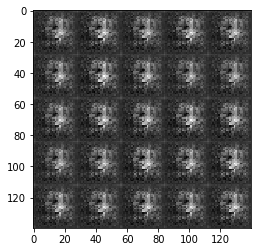

Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.4401
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 2.2873
Epoch 1/2... Discriminator Loss: 0.6043... Generator Loss: 5.2509
Epoch 1/2... Discriminator Loss: 0.4278... Generator Loss: 3.3601
Epoch 1/2... Discriminator Loss: 0.4277... Generator Loss: 4.1975
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 2.9740
Epoch 1/2... Discriminator Loss: 0.8110... Generator Loss: 8.0087
Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 7.0129
Epoch 1/2... Discriminator Loss: 0.9223... Generator Loss: 6.9641
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.8586


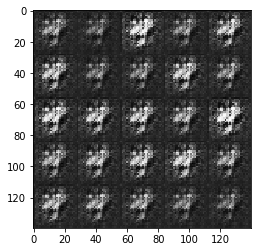

Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.6105
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 2.8218
Epoch 1/2... Discriminator Loss: 0.5445... Generator Loss: 2.2814
Epoch 1/2... Discriminator Loss: 0.6881... Generator Loss: 2.3725
Epoch 1/2... Discriminator Loss: 1.0676... Generator Loss: 1.5137
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.6766
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 3.9647
Epoch 1/2... Discriminator Loss: 0.6368... Generator Loss: 1.8930
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 2.7960
Epoch 1/2... Discriminator Loss: 0.7944... Generator Loss: 2.9120


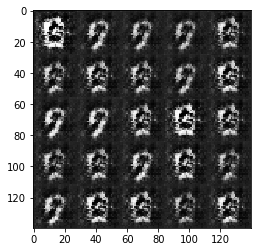

Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.6654
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 2.4799
Epoch 1/2... Discriminator Loss: 0.5221... Generator Loss: 3.7800
Epoch 1/2... Discriminator Loss: 0.5506... Generator Loss: 2.7345
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 3.6377
Epoch 1/2... Discriminator Loss: 0.6323... Generator Loss: 2.0733
Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 1.5007
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 2.9246
Epoch 1/2... Discriminator Loss: 0.6798... Generator Loss: 1.5224
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 2.3329


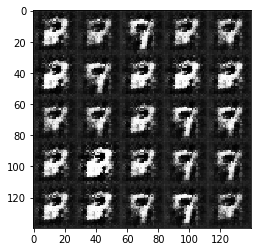

Epoch 1/2... Discriminator Loss: 0.6349... Generator Loss: 1.7095
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 3.0786
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 1.1313
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.6616
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 1.9628
Epoch 1/2... Discriminator Loss: 0.8239... Generator Loss: 2.0536
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 0.5059... Generator Loss: 2.8095
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 2.6010
Epoch 1/2... Discriminator Loss: 0.5795... Generator Loss: 1.9578


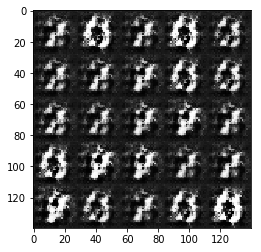

Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 5.0408
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 2.3869
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 5.8127
Epoch 1/2... Discriminator Loss: 0.5141... Generator Loss: 2.5775
Epoch 1/2... Discriminator Loss: 0.4794... Generator Loss: 2.7824
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 2.2639
Epoch 1/2... Discriminator Loss: 0.4738... Generator Loss: 2.5528
Epoch 1/2... Discriminator Loss: 0.4723... Generator Loss: 6.1525
Epoch 1/2... Discriminator Loss: 0.5804... Generator Loss: 3.8512
Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 3.4212


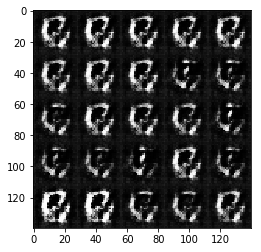

Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 2.6932
Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.7911
Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 4.1018
Epoch 1/2... Discriminator Loss: 0.5119... Generator Loss: 2.7442
Epoch 1/2... Discriminator Loss: 0.4665... Generator Loss: 2.5193
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 3.2151
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 2.2553
Epoch 1/2... Discriminator Loss: 0.4204... Generator Loss: 3.7911
Epoch 1/2... Discriminator Loss: 0.4922... Generator Loss: 2.9924
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.9089


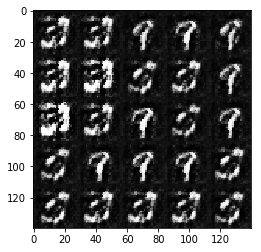

Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 2.1728
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 4.7397
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 3.1174
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 3.1882
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 3.5448
Epoch 1/2... Discriminator Loss: 0.4809... Generator Loss: 2.7521
Epoch 1/2... Discriminator Loss: 0.5379... Generator Loss: 2.1452
Epoch 1/2... Discriminator Loss: 0.4868... Generator Loss: 2.4643
Epoch 1/2... Discriminator Loss: 0.5346... Generator Loss: 2.2542
Epoch 1/2... Discriminator Loss: 0.4916... Generator Loss: 4.6931


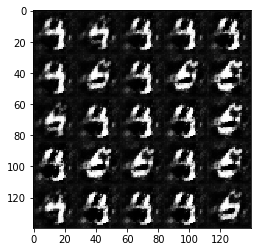

Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 3.0127
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 3.2782
Epoch 1/2... Discriminator Loss: 0.5296... Generator Loss: 2.6178
Epoch 1/2... Discriminator Loss: 0.4583... Generator Loss: 5.6195
Epoch 1/2... Discriminator Loss: 0.4623... Generator Loss: 4.4292
Epoch 1/2... Discriminator Loss: 0.4753... Generator Loss: 3.2814
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 2.7472
Epoch 1/2... Discriminator Loss: 0.6054... Generator Loss: 3.5664
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 2.0659
Epoch 1/2... Discriminator Loss: 0.4931... Generator Loss: 2.5587


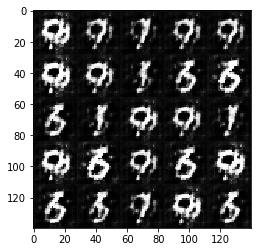

Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 3.7579
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 3.5731
Epoch 2/2... Discriminator Loss: 0.4563... Generator Loss: 2.7530
Epoch 2/2... Discriminator Loss: 0.4487... Generator Loss: 3.2767
Epoch 2/2... Discriminator Loss: 0.4621... Generator Loss: 2.3393
Epoch 2/2... Discriminator Loss: 0.5117... Generator Loss: 3.1396
Epoch 2/2... Discriminator Loss: 0.4810... Generator Loss: 3.7935
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 5.9298
Epoch 2/2... Discriminator Loss: 0.4790... Generator Loss: 2.8854


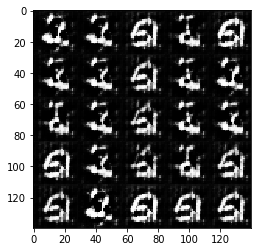

Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 4.0967
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 2.1266
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 1.8370
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 3.1397
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 3.4405
Epoch 2/2... Discriminator Loss: 0.4639... Generator Loss: 3.1731
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.2777
Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 2.2912
Epoch 2/2... Discriminator Loss: 0.4830... Generator Loss: 3.1571
Epoch 2/2... Discriminator Loss: 0.5716... Generator Loss: 2.0430


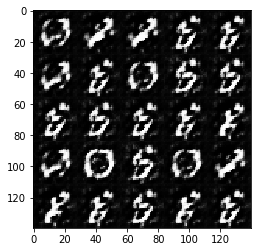

Epoch 2/2... Discriminator Loss: 0.4275... Generator Loss: 7.2056
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.4178
Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.9617
Epoch 2/2... Discriminator Loss: 0.4697... Generator Loss: 2.5217
Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 3.2945
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 2.3448
Epoch 2/2... Discriminator Loss: 0.5029... Generator Loss: 2.6718
Epoch 2/2... Discriminator Loss: 0.5187... Generator Loss: 2.2729
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 1.8498
Epoch 2/2... Discriminator Loss: 0.5891... Generator Loss: 2.0372


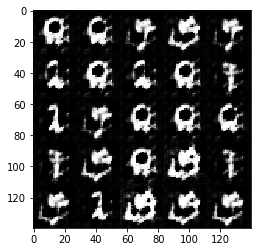

Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.4971
Epoch 2/2... Discriminator Loss: 0.4438... Generator Loss: 3.0976
Epoch 2/2... Discriminator Loss: 0.5417... Generator Loss: 3.9465
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 3.6176
Epoch 2/2... Discriminator Loss: 0.4815... Generator Loss: 3.0047
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 2.9952
Epoch 2/2... Discriminator Loss: 0.7610... Generator Loss: 1.5327
Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 2.4876
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.6456
Epoch 2/2... Discriminator Loss: 0.3993... Generator Loss: 4.3930


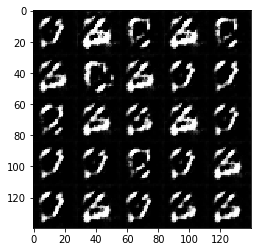

Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 3.8509
Epoch 2/2... Discriminator Loss: 0.4541... Generator Loss: 3.8396
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 3.8130
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 2.2022
Epoch 2/2... Discriminator Loss: 0.4697... Generator Loss: 3.6804
Epoch 2/2... Discriminator Loss: 0.4726... Generator Loss: 3.6192
Epoch 2/2... Discriminator Loss: 0.5019... Generator Loss: 4.8870
Epoch 2/2... Discriminator Loss: 0.5624... Generator Loss: 1.9734
Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 3.8394
Epoch 2/2... Discriminator Loss: 0.4629... Generator Loss: 4.9461


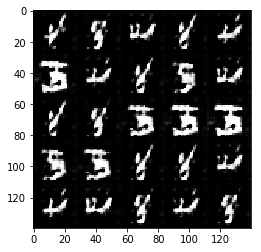

Epoch 2/2... Discriminator Loss: 0.4223... Generator Loss: 4.7348
Epoch 2/2... Discriminator Loss: 0.4451... Generator Loss: 3.1016
Epoch 2/2... Discriminator Loss: 0.4754... Generator Loss: 3.5144
Epoch 2/2... Discriminator Loss: 1.1037... Generator Loss: 1.2368
Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.7797
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 3.5144
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 3.0401
Epoch 2/2... Discriminator Loss: 0.4969... Generator Loss: 2.6264
Epoch 2/2... Discriminator Loss: 0.5005... Generator Loss: 3.3099
Epoch 2/2... Discriminator Loss: 0.5027... Generator Loss: 4.0552


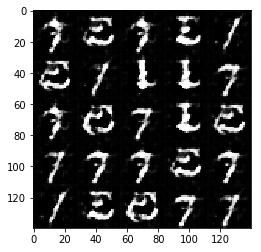

Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.7574
Epoch 2/2... Discriminator Loss: 0.4218... Generator Loss: 3.6261
Epoch 2/2... Discriminator Loss: 2.3318... Generator Loss: 0.2431
Epoch 2/2... Discriminator Loss: 0.4388... Generator Loss: 3.2070
Epoch 2/2... Discriminator Loss: 0.4472... Generator Loss: 2.9778
Epoch 2/2... Discriminator Loss: 0.4804... Generator Loss: 3.0584
Epoch 2/2... Discriminator Loss: 0.4312... Generator Loss: 3.8429
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 3.0883
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.9514
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 1.6817


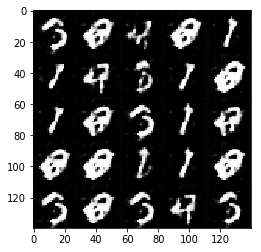

Epoch 2/2... Discriminator Loss: 0.4793... Generator Loss: 2.5112
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.7482
Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 2.8049
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 3.5778
Epoch 2/2... Discriminator Loss: 0.9362... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 0.4870... Generator Loss: 3.0666
Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 4.7293
Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 2.5117
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 2.1700
Epoch 2/2... Discriminator Loss: 0.4377... Generator Loss: 2.8542


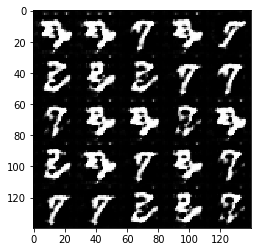

Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 2.9267
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 4.6404
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 2.4975
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.6485
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 3.1858
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 3.6025
Epoch 2/2... Discriminator Loss: 0.4114... Generator Loss: 4.0029
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 2.4164
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 2.1551
Epoch 2/2... Discriminator Loss: 1.1123... Generator Loss: 6.1302


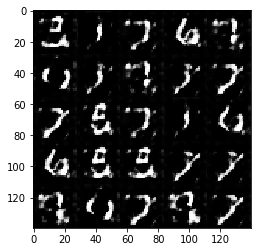

Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 2.8418
Epoch 2/2... Discriminator Loss: 0.4331... Generator Loss: 3.4235
Epoch 2/2... Discriminator Loss: 0.4351... Generator Loss: 3.1563
Epoch 2/2... Discriminator Loss: 0.5079... Generator Loss: 2.4720
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 2.8478
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 3.4091
Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 2.8942


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.7454... Generator Loss: 0.0065
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 9.6855
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 9.3607
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.3932
Epoch 1/1... Discriminator Loss: 3.5991... Generator Loss: 0.0615
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 1.1332
Epoch 1/1... Discriminator Loss: 0.4614... Generator Loss: 2.5797
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 7.1424
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.2626


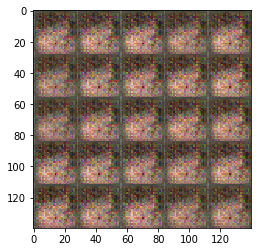

Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 3.3497
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 1.8966
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 1.7090... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.7106... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.5607
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.4536
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.3859


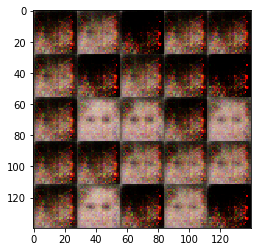

Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 3.9428
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.7831
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 4.0807
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.0127
Epoch 1/1... Discriminator Loss: 2.0849... Generator Loss: 0.3763
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 1.4329


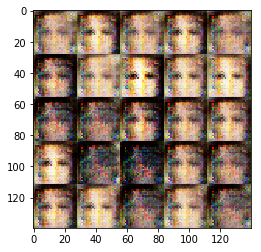

Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 2.4219
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 1.3778
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 2.2927


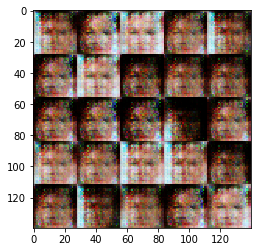

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.9402... Generator Loss: 0.3678
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.4296
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.1397
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 3.4274


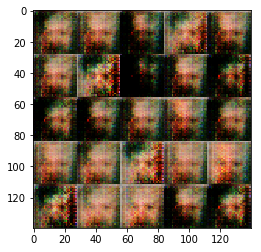

Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 2.7948
Epoch 1/1... Discriminator Loss: 2.0207... Generator Loss: 2.4701
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 2.4340
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 2.0021
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 2.5228
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.6467
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 2.0242


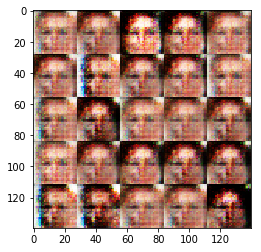

Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.4618
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 3.1837
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 2.2789
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 3.9084
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.2448


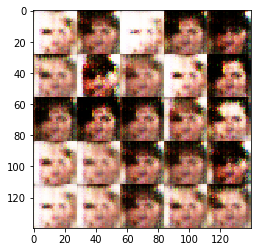

Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 2.0366
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 2.1430
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.7694
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 3.2003
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 3.3381
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.8681


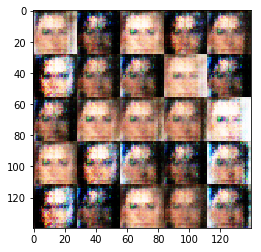

Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 2.9859
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 3.1636
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 2.2230
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 2.0692
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.0544
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.6605
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 1.4417


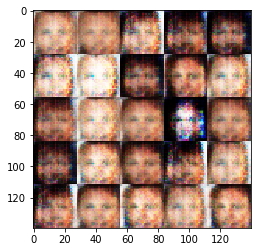

Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 2.2118
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 2.8449
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 2.0141
Epoch 1/1... Discriminator Loss: 2.0330... Generator Loss: 0.2496
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 3.5514


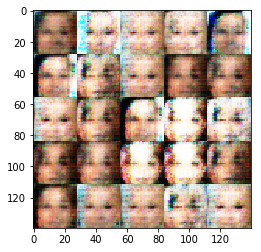

Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 2.6926
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 2.7843
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 2.9198
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 4.3972


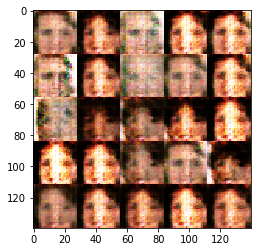

Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 3.3034
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.7509
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 4.6323
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 2.5863
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 2.0416
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 3.6342


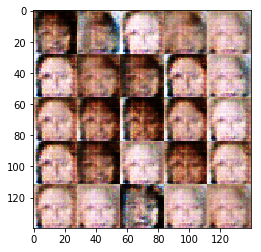

Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 3.8756
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.5813
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.5784
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 3.5844
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.8597


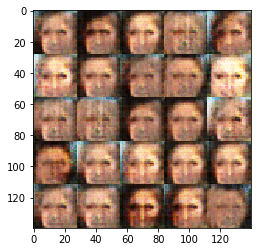

Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 3.5764
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.5100
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 5.1656
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 3.2064... Generator Loss: 7.0861


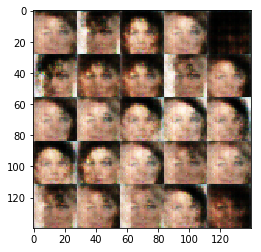

Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.9123
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 2.1106
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 2.5525
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 3.0975
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.5426
Epoch 1/1... Discriminator Loss: 0.7177... Generator Loss: 2.6042
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 2.4961


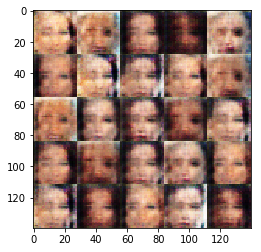

Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 2.2896
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 0.6231... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 2.1788
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9171


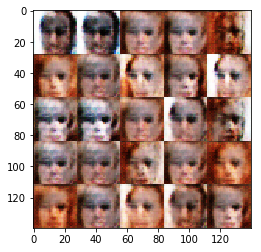

Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 2.5161
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 3.2074
Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.9859
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 3.8000
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.9753


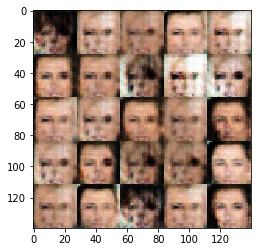

Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 1.7709
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 3.0977
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 2.3661
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 2.0449
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.0518


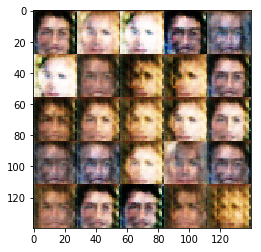

Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.5579
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.1896
Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.5319
Epoch 1/1... Discriminator Loss: 2.1665... Generator Loss: 0.2172
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.2404


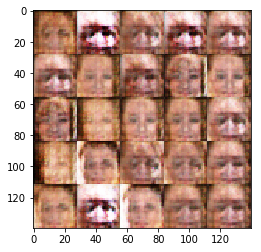

Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 1.6415
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 3.2964
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 2.1029... Generator Loss: 5.2582
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.5770


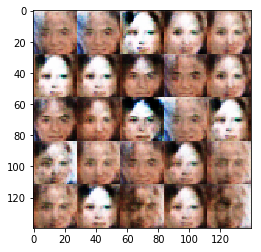

Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 2.7329
Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.0351
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.6354
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.5480
Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 2.0051
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 3.1865


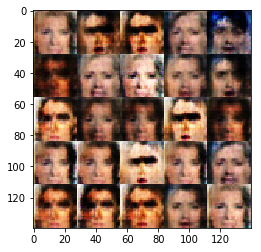

Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.3214
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 3.5548
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 4.3850
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.9371
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 2.9977
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.0848


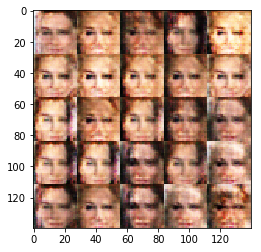

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 3.8547
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 4.0779
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 2.2608
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 2.4225
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 2.5203
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.9353
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 2.9033


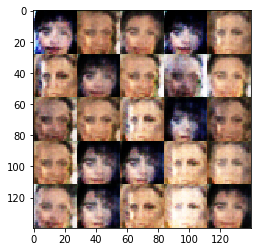

Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.7240
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.8617
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.3650
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 2.4525
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 2.0499
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 3.1190
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 3.1737


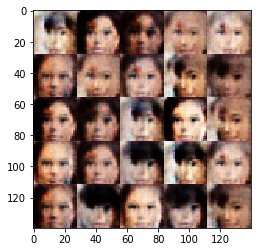

Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.7520... Generator Loss: 4.5595
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.3465
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 2.0281
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.2190
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.1431


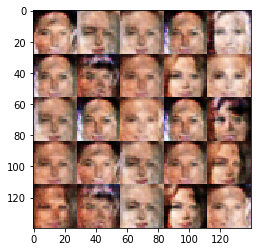

Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.9766
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 4.1079
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 2.0455
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.4222


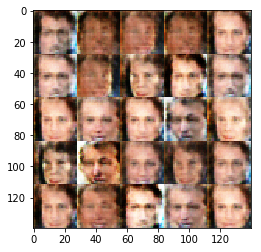

Epoch 1/1... Discriminator Loss: 2.0014... Generator Loss: 0.3017
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.3357
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 2.0153
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.3611
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 2.5297


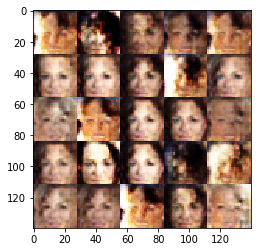

Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 0.6198... Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.0099
Epoch 1/1... Discriminator Loss: 1.9671... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.9302
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 2.8292


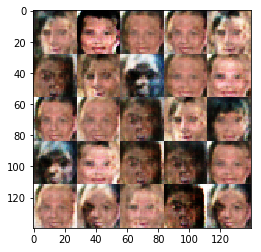

Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 2.2134
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.6612
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.7189
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.6479
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.3496


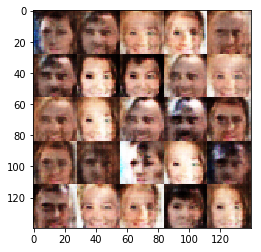

Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 2.0027
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 1.8119
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 2.3015
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 2.8753
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 3.7362
Epoch 1/1... Discriminator Loss: 0.5945... Generator Loss: 1.7319
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.5709


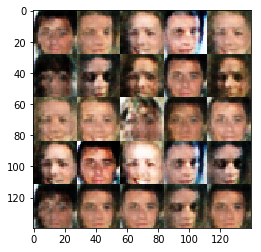

Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 2.0936
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.8606... Generator Loss: 5.0925
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.8504
Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 1.7842


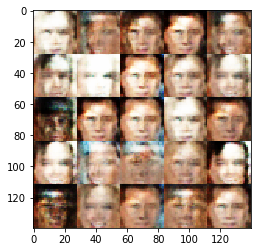

Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.2310
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 2.2648
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 2.2901
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 3.6013
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 2.5195
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9087


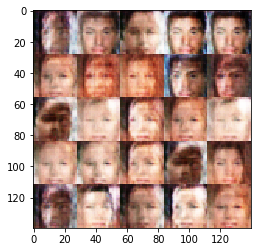

Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.6879
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.9163
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.4427
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.6078


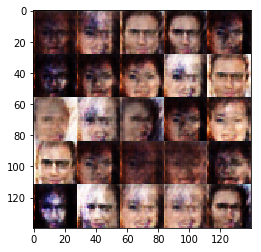

Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 2.5692
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 3.0131
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.8716... Generator Loss: 0.3034
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 1.8508


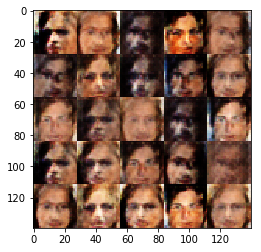

Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 1.8847
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 2.8629
Epoch 1/1... Discriminator Loss: 0.5857... Generator Loss: 1.7864
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.7297
Epoch 1/1... Discriminator Loss: 0.5061... Generator Loss: 2.5346
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 3.3820
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 1.9505


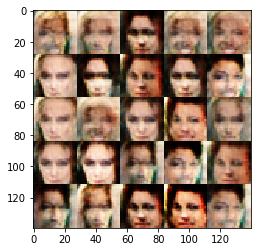

Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.8104
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 4.0925
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 2.1891
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6194


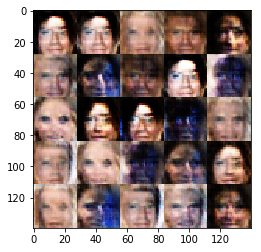

Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.5273
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 2.2924
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 1.9169
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.9910
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 3.6250
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 2.9910
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.7060
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 3.8626


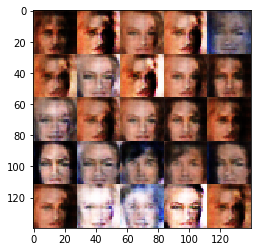

Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.6950
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 6.4981
Epoch 1/1... Discriminator Loss: 0.5784... Generator Loss: 2.5539
Epoch 1/1... Discriminator Loss: 0.4787... Generator Loss: 2.3980
Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 2.9284
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 3.1593
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 3.4602
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.2538


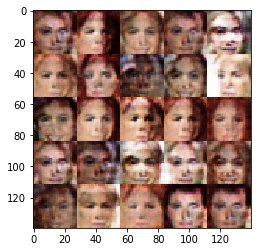

Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 3.4358
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 2.6585
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 4.1378
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.0959


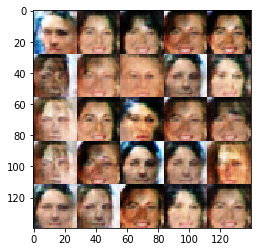

Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 2.2498
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 4.2718
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 4.5005
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.9116


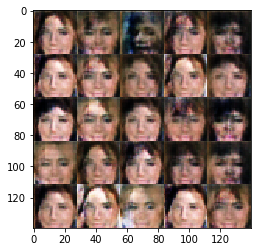

Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.7334
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.8549... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.7557
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 1.9798
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 4.4946
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.3014
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 2.5706


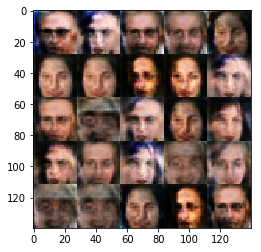

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.6040
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.5358
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 2.6093
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.9148
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 4.0989


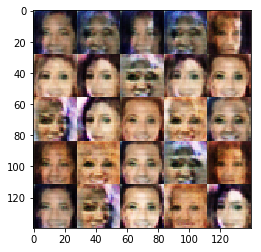

Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.7339
Epoch 1/1... Discriminator Loss: 0.9005... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.7058
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.6382
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 2.7068
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.9706
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.8282
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.7875


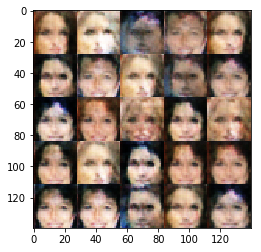

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 3.7493
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.7413
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.7175
Epoch 1/1... Discriminator Loss: 0.8789... Generator Loss: 5.7074
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 1.8898
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.6361
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 2.0975
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.6134


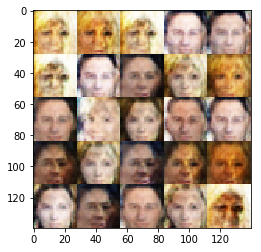

Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 2.6680
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.5956
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 4.5565
Epoch 1/1... Discriminator Loss: 2.2283... Generator Loss: 0.2937
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.8779
Epoch 1/1... Discriminator Loss: 0.6258... Generator Loss: 1.5407
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.5590
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 3.6315


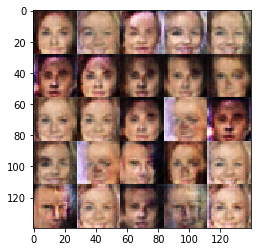

Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 2.2774
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 2.9982
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.8222
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.0965
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 2.3446
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 2.2850


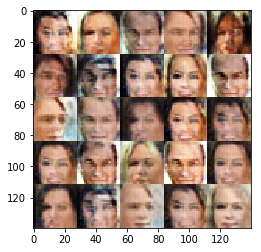

Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 2.1855
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 3.9052
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 3.2834
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.5841
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.7346
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9559


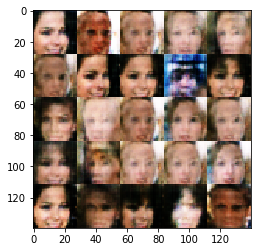

Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 2.0575
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 2.6076
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 2.9479
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 2.5725
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 3.5869
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 3.8426


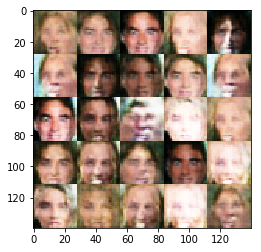

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.8516
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 3.0190
Epoch 1/1... Discriminator Loss: 0.5362... Generator Loss: 2.3680
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 3.3569


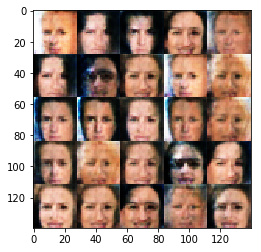

Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 2.1356
Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 2.1502
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.6163
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.4324
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 3.5631
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.5043


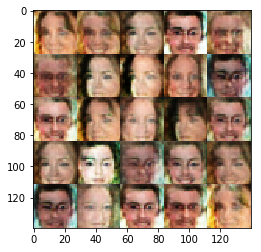

Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.7801
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 2.3626
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 2.1482


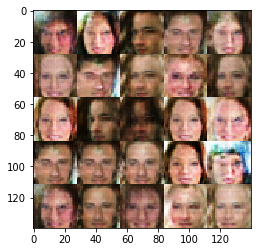

Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 3.1657
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 3.3399
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.5909
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 3.6980
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.3717


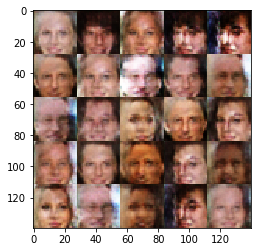

Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 4.0786
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 2.4703
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.8727
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 0.5301... Generator Loss: 3.2690
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 3.4812
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 4.0117
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.7180
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.5769
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.2581


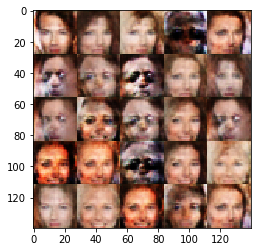

Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 2.6966
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 2.5543
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.9483
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 1.9668
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.3080
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 2.5178
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 1.7811


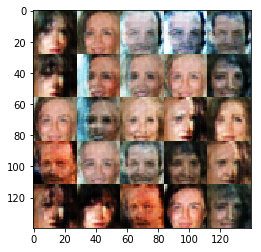

Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 2.7841
Epoch 1/1... Discriminator Loss: 0.5914... Generator Loss: 2.8902
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 2.4592
Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 2.4356
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.4376
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.3769
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 3.3086


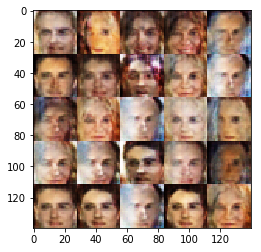

Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.2132
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 2.9437
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 5.0291
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.2171
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 1.5656
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9045


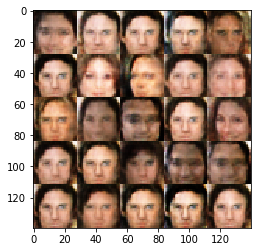

Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 2.9790
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 2.3687
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.8107
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.8091
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.5225
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 3.4955
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 2.4539


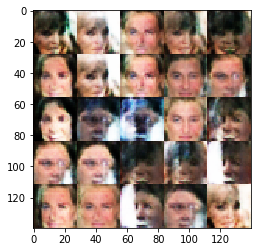

Epoch 1/1... Discriminator Loss: 0.6402... Generator Loss: 4.7523
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.7456
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.6766
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 5.0729
Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 4.4308


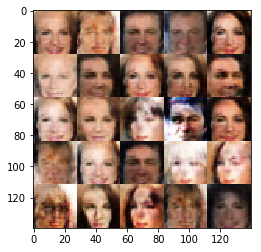

Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 2.1000
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.8012
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 3.0634
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 4.2052
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.2571
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 2.2763
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.5578
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7404


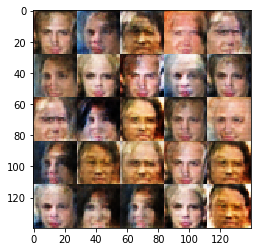

Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 2.8551
Epoch 1/1... Discriminator Loss: 0.7075... Generator Loss: 1.6957
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 2.3395
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.1904
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 2.2656
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.1680


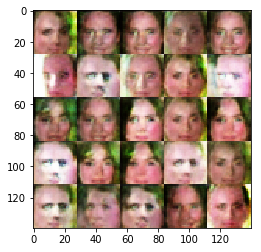

Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 2.2203
Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 2.7027
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 2.0041
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.3464
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.9837
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 2.4732
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.3348


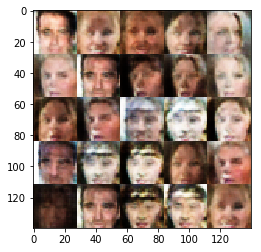

Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.6257
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.4595
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 3.0667
Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 2.7428
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 1.9666
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 1.5518


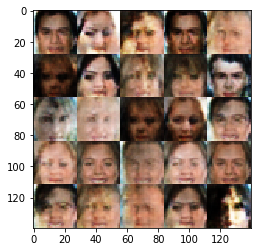

Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 2.3844
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 2.6387
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 3.1768
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 2.4651
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 4.4488
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8558


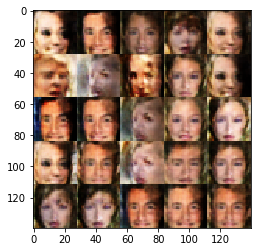

Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 2.6050
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.7738... Generator Loss: 0.3961


In [15]:
batch_size = 32
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.